Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Starting Exploratory Data Analysis...

Analyzed 50 images


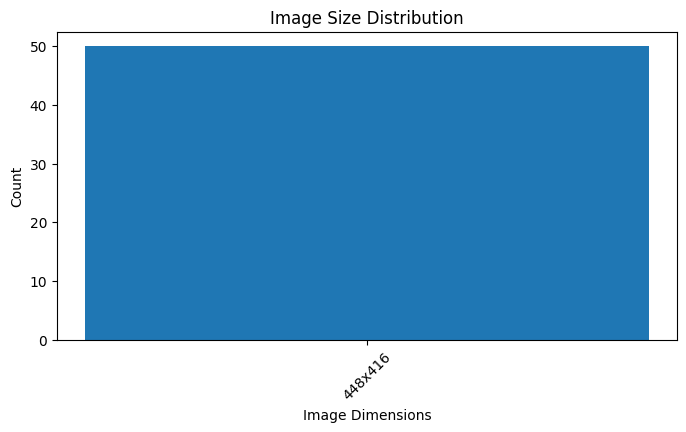

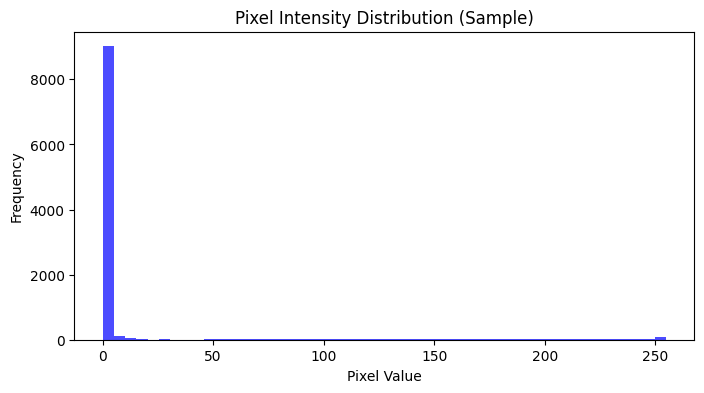

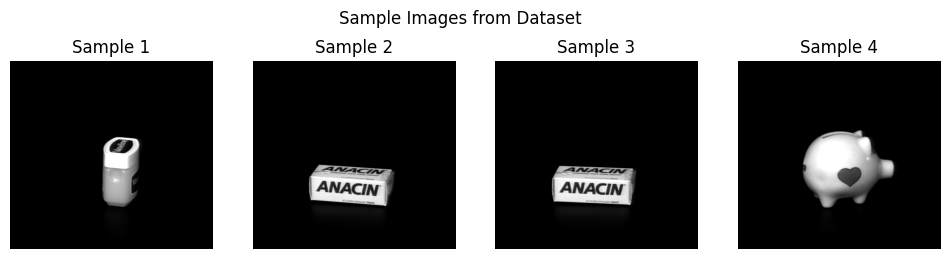


Pixel Statistics (from sample):
Mean pixel value: 13.12
Std pixel value: 47.02

Starting training...
Epoch [1/20], Loss: 1.1519
Epoch [2/20], Loss: 1.0620
Epoch [3/20], Loss: 1.0049
Epoch [4/20], Loss: 0.9598
Epoch [5/20], Loss: 0.9184
Epoch [6/20], Loss: 0.8792
Epoch [7/20], Loss: 0.8435
Epoch [8/20], Loss: 0.8108
Epoch [9/20], Loss: 0.7823
Epoch [10/20], Loss: 0.7565
Epoch [11/20], Loss: 0.7338
Epoch [12/20], Loss: 0.7135
Epoch [13/20], Loss: 0.6958
Epoch [14/20], Loss: 0.6795
Epoch [15/20], Loss: 0.6657
Epoch [16/20], Loss: 0.6531
Epoch [17/20], Loss: 0.6418
Epoch [18/20], Loss: 0.6321
Epoch [19/20], Loss: 0.6231
Epoch [20/20], Loss: 0.6158


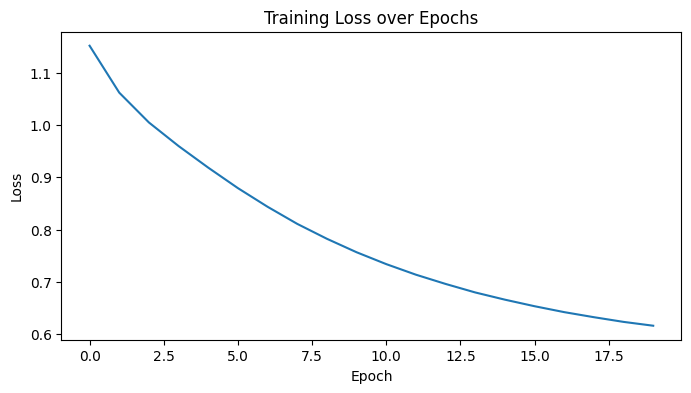

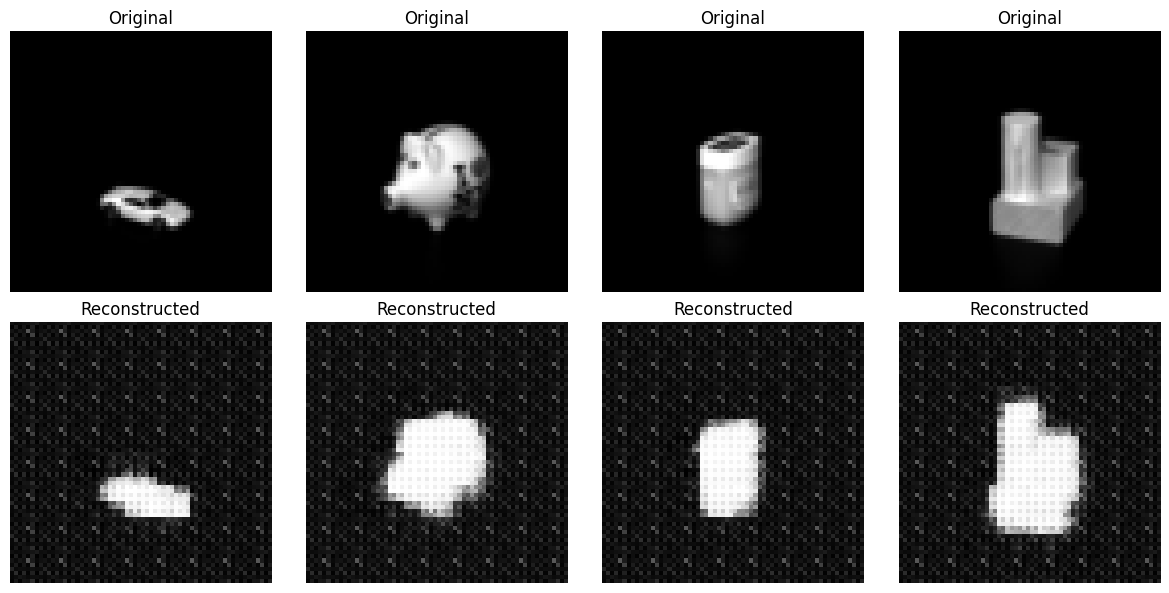

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from google.colab import drive
import gc  # Garbage collector
import random
from sklearn.decomposition import PCA
from collections import Counter

# Mount Google Drive
drive.mount('/content/drive')

class COILDataset(Dataset):
    def __init__(self, data_dir, transform=None, max_images=1000):  # Added max_images parameter
        self.data_dir = data_dir
        self.transform = transform
        all_images = [f for f in os.listdir(data_dir) if f.endswith('.png')]

        # Randomly sample if there are more images than max_images
        if len(all_images) > max_images:
            self.image_files = random.sample(all_images, max_images)
        else:
            self.image_files = all_images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, image

def perform_eda(data_dir, max_images=100):  # Reduced sample size for EDA
    """Perform Exploratory Data Analysis on a subset of the dataset"""
    print("Starting Exploratory Data Analysis...")

    # Load subset of images
    images = []
    image_sizes = []
    pixel_intensities = []

    image_files = random.sample([f for f in os.listdir(data_dir) if f.endswith('.png')],
                              min(max_images, len(os.listdir(data_dir))))

    for img_file in image_files:
        img_path = os.path.join(data_dir, img_file)
        img = Image.open(img_path).convert('L')
        images.append(np.array(img))
        image_sizes.append(img.size)
        pixel_intensities.extend(np.array(img).flatten())

        # Clear memory
        if len(images) % 20 == 0:
            gc.collect()

    # Basic statistics
    print(f"\nAnalyzed {len(images)} images")

    # Image Size Distribution
    plt.figure(figsize=(8, 4))
    sizes = Counter(image_sizes)
    plt.bar(range(len(sizes)), list(sizes.values()))
    plt.title('Image Size Distribution')
    plt.xlabel('Image Dimensions')
    plt.xticks(range(len(sizes)), [f'{s[0]}x{s[1]}' for s in sizes.keys()], rotation=45)
    plt.ylabel('Count')
    plt.show()

    # Pixel Intensity Distribution (using subset)
    plt.figure(figsize=(8, 4))
    sample_intensities = random.sample(pixel_intensities, min(10000, len(pixel_intensities)))
    plt.hist(sample_intensities, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution (Sample)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

    # Sample Images Display (reduced number)
    plt.figure(figsize=(12, 3))
    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Sample {i+1}')
    plt.suptitle('Sample Images from Dataset')
    plt.show()

    # Basic statistics
    intensities_array = np.array(sample_intensities)
    mean_val = np.mean(intensities_array)
    std_val = np.std(intensities_array)

    print("\nPixel Statistics (from sample):")
    print(f"Mean pixel value: {mean_val:.2f}")
    print(f"Std pixel value: {std_val:.2f}")

    # Clear memory
    del images, pixel_intensities, intensities_array
    gc.collect()

    return mean_val, std_val

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        # Reduced number of filters
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),  # Reduced from 16 to 8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, padding=1),  # Reduced from 32 to 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),  # Reduced from 64 to 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 2, stride=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(8, 1, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Clear memory
            if batch_idx % 10 == 0:
                gc.collect()
                torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return train_losses

def main():
    # Memory optimization settings
    torch.backends.cudnn.benchmark = True

    # Parameters for reduced dataset
    MAX_IMAGES = 500  # Reduce total number of images
    BATCH_SIZE = 16   # Reduce batch size
    IMAGE_SIZE = 64   # Reduce image size
    NUM_EPOCHS = 20   # Reduce number of epochs

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set paths
    data_dir = '/content/drive/MyDrive/coil-20-proc'  # Update with your path

    # Perform EDA on subset
    mean_pixel, std_pixel = perform_eda(data_dir, max_images=50)

    # Data transforms with smaller image size
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean_pixel/255.0], std=[std_pixel/255.0])
    ])

    # Load reduced dataset
    dataset = COILDataset(data_dir, transform=transform, max_images=MAX_IMAGES)

    # Split dataset
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create data loaders with smaller batch size
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    model = CNNAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    print("\nStarting training...")
    train_losses = train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, device)

    # Plot training loss
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Evaluate and show sample results
    model.eval()
    with torch.no_grad():
        sample_data = next(iter(test_loader))
        images = sample_data[0][:4].to(device)
        outputs = model(images)

        # Display results
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        for i in range(4):
            # Original images
            axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            # Reconstructed images
            axes[1, i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstructed')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()